In [15]:
import numpy as np
import pandas as pd
import os
from glob import iglob, glob
import matplotlib.pyplot as plt
from itertools import chain

%matplotlib inline

In [16]:
dataframe = pd.read_csv('../input/sample_labels.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../input/*','images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', dataframe.shape[0])
dataframe['path'] = dataframe['Image Index'].map(all_image_paths.get)
dataframe['Patient Age'] = dataframe['Patient Age'].map(lambda x: int(x[:-1]))

Scans found: 5606 , Total Headers 5606


In [17]:
dataframe = dataframe[dataframe['Finding Labels'] != 'No Finding']
all_labels = np.unique(list(chain(*dataframe['Finding Labels'].map(lambda x: x.split('|')).tolist())))
pathology_list = all_labels
dataframe['path'] = dataframe['Image Index'].map(all_image_paths.get)
dataframe = dataframe.drop(['Patient Age', 'Patient Gender', 'Follow-up #', 'Patient ID', 'View Position', 
         'OriginalImageWidth', 'OriginalImageHeight', 'OriginalImagePixelSpacing_x','OriginalImagePixelSpacing_y'], axis=1)
for pathology in pathology_list :
    dataframe[pathology] = dataframe['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)
dataframe = dataframe.drop(['Image Index', 'Finding Labels'], axis=1)

In [18]:
dataframe['disease_vec'] = dataframe.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(dataframe, 
                                   test_size = 0.25, 
                                   random_state = 2018)

In [20]:
X_train = train_df['path'].values.tolist()
y_train = np.asarray(train_df['disease_vec'].values.tolist())
X_test = test_df['path'].values.tolist()
y_test = np.asarray(test_df['disease_vec'].values.tolist())

In [21]:
from skimage.io import imread, imshow
print(imread(X_train[0]).shape)
images_train = np.zeros([len(X_train),128,128])
for i, x in enumerate(X_train):
    image = imread(x, as_gray=True)[::8,::8]
    images_train[i] = (image - image.min())/(image.max() - image.min())
images_test = np.zeros([len(X_test),128,128])
for i, x in enumerate(X_test):
    image = imread(x, as_gray=True)[::8,::8]
    images_test[i] = (image - image.min())/(image.max() - image.min())

(1024, 1024)


In [22]:
X_train = images_train.reshape(len(X_train), 128, 128, 1)
X_test = images_test.reshape(len(X_test), 128, 128, 1)
X_train.astype('float32')

array([[[[0.63786006],
         [0.47736627],
         [0.22222222],
         ...,
         [0.4814815 ],
         [0.5020576 ],
         [0.5144033 ]],

        [[0.62139916],
         [0.47325101],
         [0.2345679 ],
         ...,
         [0.14814815],
         [0.14403293],
         [0.14403293]],

        [[0.6255144 ],
         [0.4814815 ],
         [0.22633745],
         ...,
         [0.05349794],
         [0.04938272],
         [0.04938272]],

        ...,

        [[0.13580246],
         [0.16872428],
         [0.25925925],
         ...,
         [0.05349794],
         [0.16049382],
         [0.34567901]],

        [[0.1563786 ],
         [0.18930042],
         [0.30452675],
         ...,
         [0.05761317],
         [0.16049382],
         [0.36625513]],

        [[0.20164609],
         [0.2345679 ],
         [0.35390946],
         ...,
         [0.06584362],
         [0.15226337],
         [0.34979424]]],


       [[[0.00421941],
         [0.00421941],
         [0.00

In [23]:
from keras.models import Sequential
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.applications.xception import Xception
base_model = Xception(input_shape = (128, 128, 1), 
                                 include_top = False, weights = None)
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Dense(len(all_labels), activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20860904  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 14)                7182      
Total params: 21,917,174
Trainable params: 21,862,646
Non-trainable params: 54,528
___________________________________________________________

In [24]:
history = model.fit(X_train, y_train, epochs = 30, verbose=1, validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 1921 samples, validate on 641 samples
Epoch 1/30
1921/1921 [==============================] - 25s 13ms/step - loss: 0.3550 - acc: 0.8876 - val_loss: 0.4967 - val_acc: 0.8840
Epoch 2/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3176 - acc: 0.8889 - val_loss: 0.3543 - val_acc: 0.8878
Epoch 3/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3183 - acc: 0.8895 - val_loss: 0.5102 - val_acc: 0.8848
Epoch 4/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3144 - acc: 0.8898 - val_loss: 0.3852 - val_acc: 0.8695
Epoch 5/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3170 - acc: 0.8899 - val_loss: 1.9911 - val_acc: 0.8707
Epoch 6/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3141 - acc: 0.8898 - val_loss: 2.2563 - val_acc: 0.8556
Epoch 7/30
1921/1921 [==============================] - 9s 5ms/step - loss: 0.3151 - acc: 0.8896 - 

In [25]:
def history_plot(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

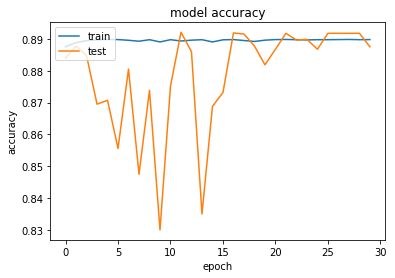

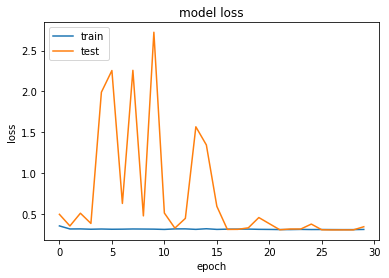

In [26]:
history_plot(history)

In [27]:
predictions = model.predict(X_test, batch_size = 32, verbose = True)

641/641 [==============================] - 3s 4ms/step


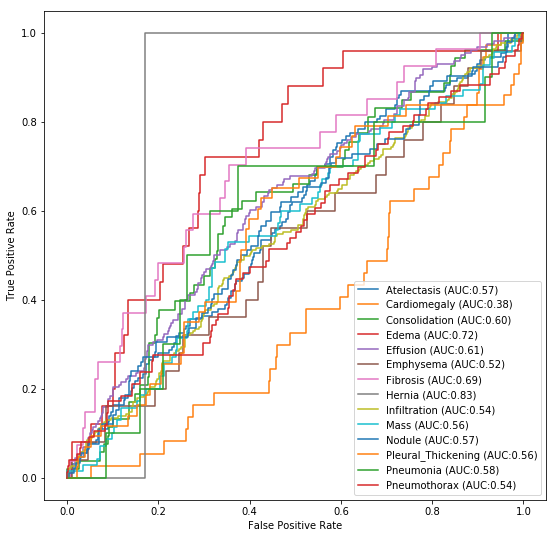

In [28]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), predictions[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

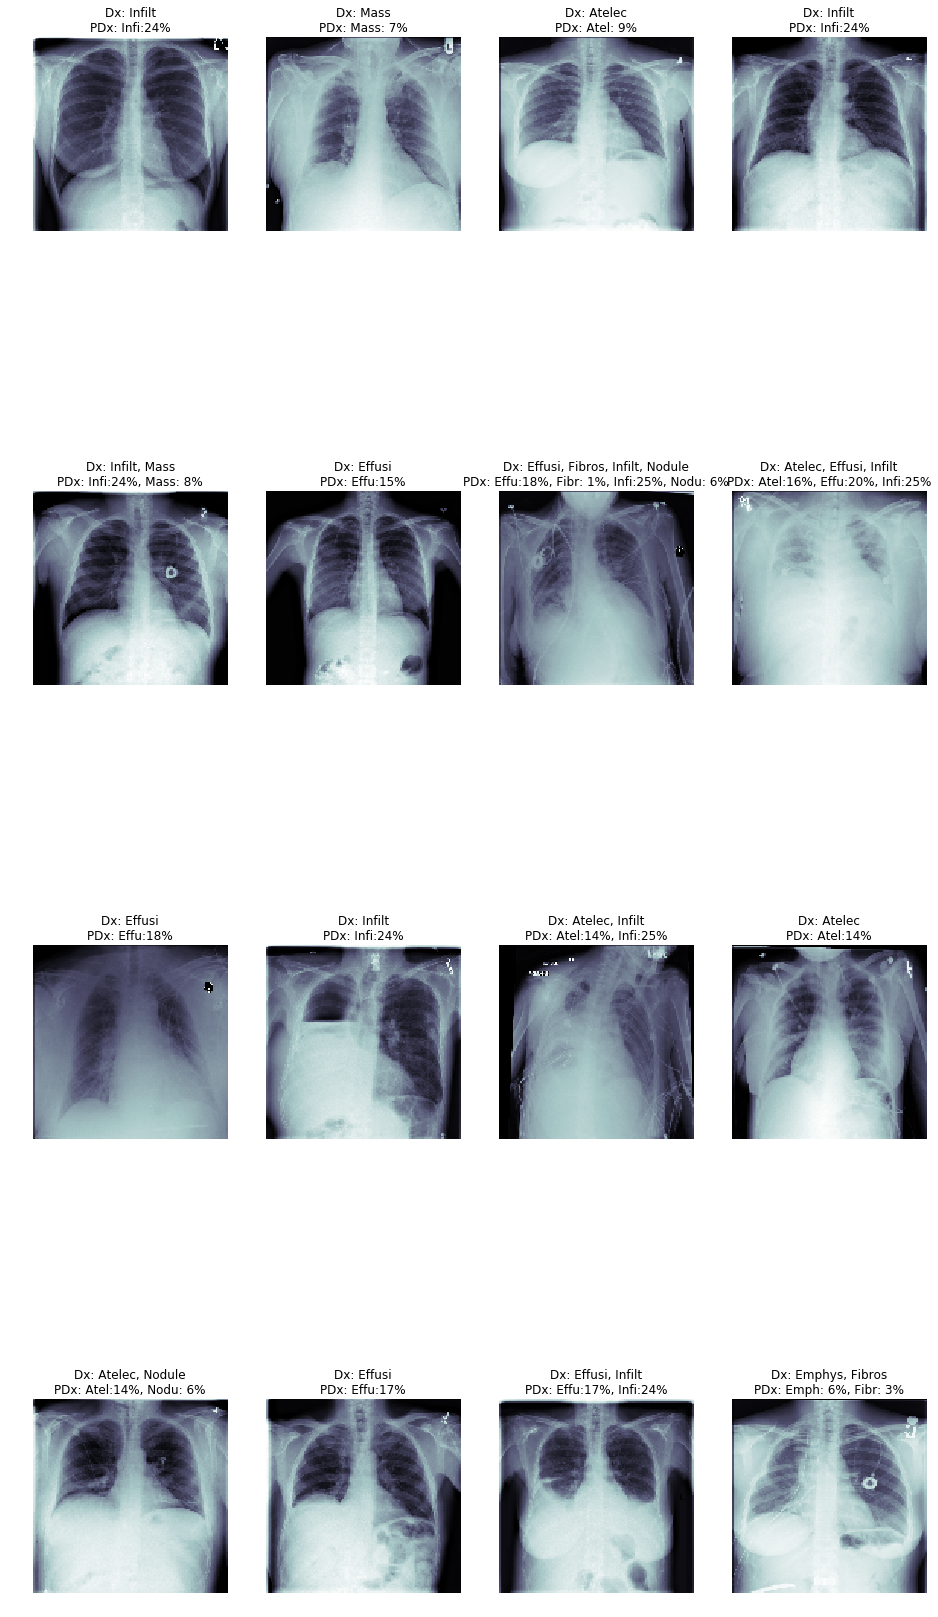

In [29]:
sickest_idx = np.argsort(np.sum(y_test, 1)<1)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(X_test[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  y_test[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  y_test[idx], predictions[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')